
# Fraud Detection Assignment — End‑to‑End Solution
**Author:** Yash Bhardwaj

This notebook is structured to satisfy all deliverables in the brief:

1) **Data cleaning**: missing values, outliers, multicollinearity  
2) **Model**: end‑to‑end build with rationale  
3) **Feature selection rationale**  
4) **Performance demonstration**: rigorous, time‑aware validation, metrics, plots  
5) **Key fraud drivers** (global + local explainability)  
6) **Sanity of factors** (business reasoning)  
7) **Prevention recommendations**  
8) **Measurement plan**


In [ ]:
%pip install pandas numpy scikit-learn lightgbm xgboost shap matplotlib plotly tqdm pyarrow fastparquet

import os, gc, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report, roc_curve
)

import matplotlib.pyplot as plt

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

print("Packages -> LGBM:", HAS_LGBM, "| XGB:", HAS_XGB, "| SHAP:", HAS_SHAP)


  Using cached pandas-2.3.2-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached xgboost-3.0.4-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached shap-0.48.0-cp313-cp313-win_amd64.whl.metadata (25 kB)
  Using cached matplotlib-3.10.5-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached plotly-6.3.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached fastparquet-2024.11.0-cp313-cp313-win_amd64.whl.metadata (4.3 kB)
  Using cached numba-0.61.2-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
Using cached pandas-2.3.2-cp313-cp313-win_amd64.whl (11.0 MB)
Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl (8.7 MB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Using cached xgboost-3.0.4-py3-none-win_amd64.whl (56.8 MB)
Using cached shap-0.48.0-c


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Packages -> LGBM: True | XGB: True | SHAP: True


In [ ]:

DATA_PATH = r'C:\Users\yashh\Fraud Detection Model\dataset\Fraud.csv'
RANDOM_STATE = 42
TEST_SIZE = 0.20 
TARGET_COL = "isFraud"

# optmizing memory for smooth operations
DTYPES = {
    "step": "int32",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Please update DATA_PATH."
print('Using dataset at:', DATA_PATH) # just to make sure if the data is present on the specified path


Using dataset at: C:\Users\yashh\Fraud Detection Model\dataset\Fraud.csv


In [ ]:
df = pd.read_csv(DATA_PATH, dtype=DTYPES)
print(df.shape)
df.head(3)


(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0


In [ ]:
# getting basic info of the dataset and checking if there are any missing values in the data

print(df.info())

print("\nTarget balance:")
print(df[TARGET_COL].value_counts(normalize=True).rename('proportion'))

print("\n NaN values or missing values per column:")
print(df.isna().sum())

# getting stats for numerical columns for better understanding of the dataset's numerical values
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

df[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])



Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int32   
 1   type            category
 2   amount          float32 
 3   nameOrig        category
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        category
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         int8    
 10  isFlaggedFraud  int8    
dtypes: category(3), float32(5), int32(1), int8(2)
memory usage: 475.1 MB
None

Target balance:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Numeric columns: ['step', 'amount', 'oldbalanceOrg', 'new

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338834e+05,8.551137e+05,1.100702e+06,1.224997e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924048e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,9.000000e+00,4.494676e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5%,1.600000e+01,2.224100e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
95%,4.900000e+02,5.186342e+05,5.823702e+06,5.980262e+06,5.147230e+06,5.515716e+06,0.000000e+00,0.000000e+00


## Exploratory Data Analysis (target leakage, distributions, imbalances)

isFraud          0         1
type                        
CASH_IN   1.000000  0.000000
CASH_OUT  0.998160  0.001840
DEBIT     1.000000  0.000000
PAYMENT   1.000000  0.000000
TRANSFER  0.992312  0.007688


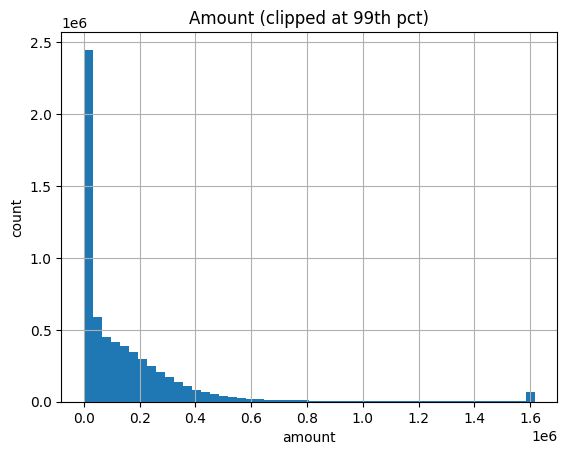

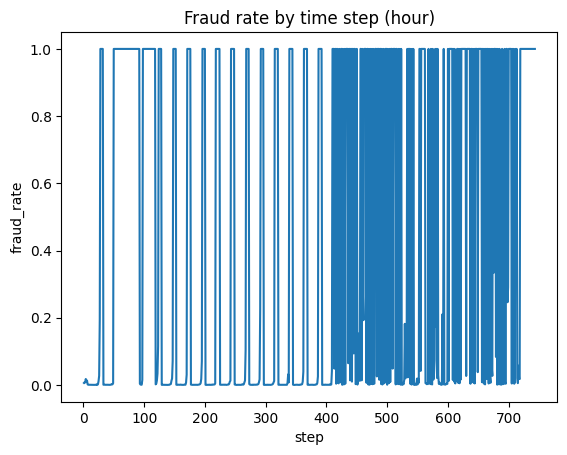

In [ ]:

# Target vs type using contingency matrix
# the values will show proportions of fraud and non fraud transaction per transaction type 
# like for CASH_IN the row will display how many transactions are fraud and non fraud(normalized).
ct = pd.crosstab(df['type'], df[TARGET_COL], normalize='index') 
print(ct) 

# Distribution of amounts (trimmed): here after clipping the amount column the amount values more than the
# 99th percentile are replaced by the 99th percentile and value below it stays the same.
amt_quantiled_At_99 = df['amount'].quantile(0.99)
df['amount_clip'] = df['amount'].clip(upper=amt_quantiled_At_99)
df['amount_clip'].hist(bins=50)
plt.title('Amount (clipped at 99th percentile)')
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

# Time progression of fraud rate i.e. how the fraud rate changes over time
fraud_rate_by_step = df.groupby('step')[TARGET_COL].mean()
fraud_rate_by_step.plot()
plt.title('Fraud rate by time step (hour)')
plt.xlabel('step')
plt.ylabel('fraud_rate')
plt.show()


## Feature Engineering

In [ ]:

# Derived risk features: these are necessary because most probable frauds are for type : cash and transfer
df['is_type_TRANSFER'] = (df['type'] == 'TRANSFER').astype('int8') # Creates a binary indicator: 1 if type = TRANSFER, else 0.
df['is_type_CASH_OUT'] = (df['type'] == 'CASH_OUT').astype('int8') # Creates a binary indicator: 1 if type = CASH_OUT, else 0.
df['is_merchant_dest'] = df['nameDest'].astype(str).str.startswith('M').astype('int8') # Creates a feature indicating whether the destination account is a merchant.

# Balance deltas for origin
df['deltaOrig'] = (df['oldbalanceOrg'] - df['newbalanceOrig']).astype('float32') # money debited from the origin account
df['deltaDest'] = (df['newbalanceDest'] - df['oldbalanceDest']).astype('float32') # money credited to the destination account after the transaction

# detecting abnormal patterns like amount is positive but the balance was zero
df['orig_balance_zero_then_txn'] = ((df['oldbalanceOrg'] == 0) & (df['amount'] > 0)).astype('int8') # balance of origin account is zero and but transaction still happened
df['dest_balance_zero_then_in'] = ((df['oldbalanceDest'] == 0) & (df['amount'] > 0)).astype('int8') # balance of destination account is zero and but still received money
df['mismatch_orig'] = (np.abs(df['deltaOrig'] - df['amount']) > 1e-2).astype('int8') # the amount and deltaorg should be equal normally but mismatch creates suspicion
df['mismatch_dest'] = (np.abs(df['deltaDest'] - df['amount']) > 1e-2).astype('int8')

# Drop leakage columns (IDs kept only if used as categorical signals) i.e. dropping the information or features that will not be available at the prediction time
LEAKS = []  # if later any more such features are found those can be appended here
feature_cols = [c for c in df.columns if c not in [TARGET_COL, 'isFlaggedFraud', 'amount_clip'] + LEAKS] # getting the columns that are not present in [TARGET_COL, 'isFlaggedFraud', 'amount_clip'] + LEAKS]
print("Feature count:", len(feature_cols))
feature_cols[:15]


Feature count: 18


['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'is_type_TRANSFER',
 'is_type_CASH_OUT',
 'is_merchant_dest',
 'deltaOrig',
 'deltaDest',
 'orig_balance_zero_then_txn']

## Train/Validation Split (Time‑aware)

In [ ]:

# we will be using time aware split here that is using past data to detect the future fraud possibilities analogous to real world scenario
# time here is define by step hence splitting using step column
step_cut = int(df['step'].quantile(0.80))
train_idx = df['step'] <= step_cut
valid_idx = df['step'] > step_cut

train = df.loc[train_idx].reset_index(drop=True)
valid = df.loc[valid_idx].reset_index(drop=True)

X_train = train[feature_cols]
y_train = train[TARGET_COL].astype('int8')
X_valid = valid[feature_cols]
y_valid = valid[TARGET_COL].astype('int8')

print(train.shape, valid.shape, " | step_cut:", step_cut)

# simply encoding the categorial data as numbers are better understood by a machine learning model
for c in X_train.select_dtypes(include=['category']).columns:
    # Ensure consistent codes between train/valid
    allcats = pd.Categorical(df[c])
    cat2code = {cat: i for i, cat in enumerate(allcats.categories)}
    X_train[c] = pd.Categorical(X_train[c], categories=allcats.categories).codes.astype('int32')
    X_valid[c] = pd.Categorical(X_valid[c], categories=allcats.categories).codes.astype('int32')

# Fill remaining NaNs if any
X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)


(5113884, 21) (1248736, 21)  | step_cut: 355


## Baseline Models

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.999992	valid's auc: 0.962171
Early stopping, best iteration is:
[1]	train's auc: 0.990213	valid's auc: 0.990873
AUC: 0.98221 | Average Precision (PR AUC): 0.08783
Confusion Matrix:
 [[1202747   41739]
 [    171    4079]]

Classification report:
               precision    recall  f1-score   support

           0     0.9999    0.9665    0.9829   1244486
           1     0.0890    0.9598    0.1629      4250

    accuracy                         0.9664   1248736
   macro avg     0.5444    0.9631    0.5729   1248736
weighted avg     0.9968    0.9664    0.9801   1248736



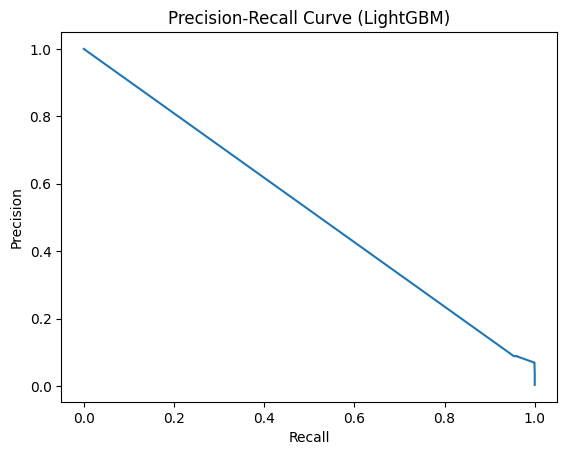

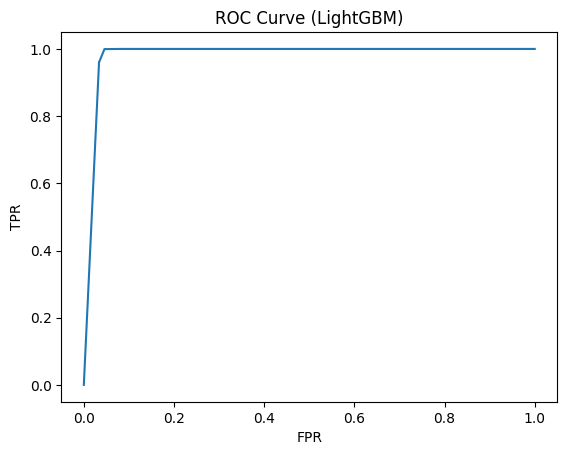

In [ ]:
# in this section we will be training base models i.e. no hyper parameter tuning and and will produce the classification report with 
# appropriate scores and curves
def evaluate_predictions(y_true, y_prob, threshold=0.5, title_suffix=""):


    y_pred = (y_prob >= threshold).astype(int)

    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)


    print(f"AUC: {auc:.5f} | Average Precision (PR AUC): {ap:.5f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

    # Precision Recall (PR) Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision)
    plt.title(f'Precision-Recall Curve {title_suffix}')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve {title_suffix}')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.show()



# using LightGBM :
if HAS_LGBM:
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
    params = {
        'objective': 'binary',
        'metric': ['auc'],
        'learning_rate': 0.05,
        'num_leaves': 64,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 2,
        'reg_lambda': 5.0,
        'min_data_in_leaf': 50,
        'max_depth': -1,
        'verbose': -1,
        'scale_pos_weight': max(1.0, (y_train==0).sum() / max(1,(y_train==1).sum())),
        'seed': 42
    }


    from lightgbm import early_stopping, log_evaluation

    lgb_model = lgb.train(
       params,
       lgb_train,
       valid_sets=[lgb_train, lgb_valid],
       valid_names=['train','valid'],
       num_boost_round=2000,
       callbacks=[early_stopping(100), log_evaluation(100)]
    )

    y_valid_prob_lgb = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
    evaluate_predictions(y_valid, y_valid_prob_lgb, title_suffix="(LightGBM)")
else:
    print("LightGBM not available; skipping.")


Training XGBoost with params: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.05, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 5.0, 'scale_pos_weight': np.float64(1289.4072672218017), 'seed': 42}
[0]	train-auc:0.99798	valid-auc:0.99562
[200]	train-auc:0.99999	valid-auc:0.99999
[256]	train-auc:1.00000	valid-auc:0.99999
AUC: 0.99999 | Average Precision (PR AUC): 0.99665
Confusion Matrix:
 [[1244297     189]
 [     84    4166]]

Classification report:
               precision    recall  f1-score   support

           0     0.9999    0.9998    0.9999   1244486
           1     0.9566    0.9802    0.9683      4250

    accuracy                         0.9998   1248736
   macro avg     0.9783    0.9900    0.9841   1248736
weighted avg     0.9998    0.9998    0.9998   1248736



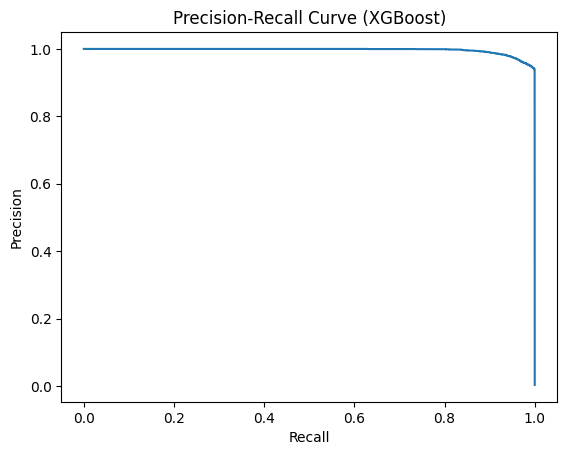

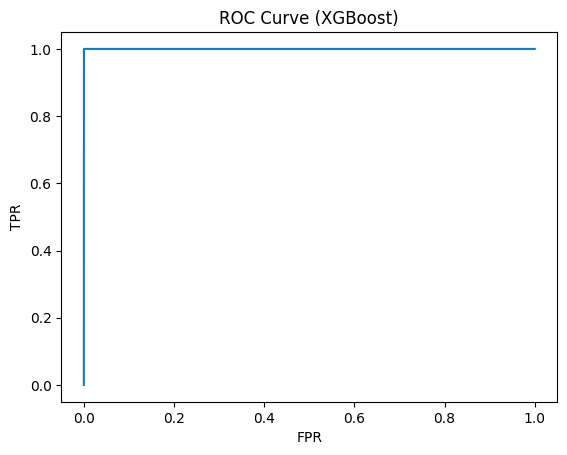

In [ ]:

if HAS_XGB:
    dtrain = xgb.DMatrix(X_train, label=y_train) # specifying labels and features
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    scale_pos_weight = max(1.0, (y_train==0).sum() / max(1,(y_train==1).sum()))
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': 0.05,
        'max_depth': 8,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda': 5.0,
        'scale_pos_weight': scale_pos_weight,
        'seed': 42
    }
    print("Training XGBoost with params:", xgb_params)
    xgb_model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=3000,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        early_stopping_rounds=100,
        verbose_eval=200
    )
    y_valid_prob_xgb = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
    evaluate_predictions(y_valid, y_valid_prob_xgb, title_suffix="(XGBoost)")
else:
    print("XGBoost not available; skipping.")


## Explainability — Feature Importance & SHAP

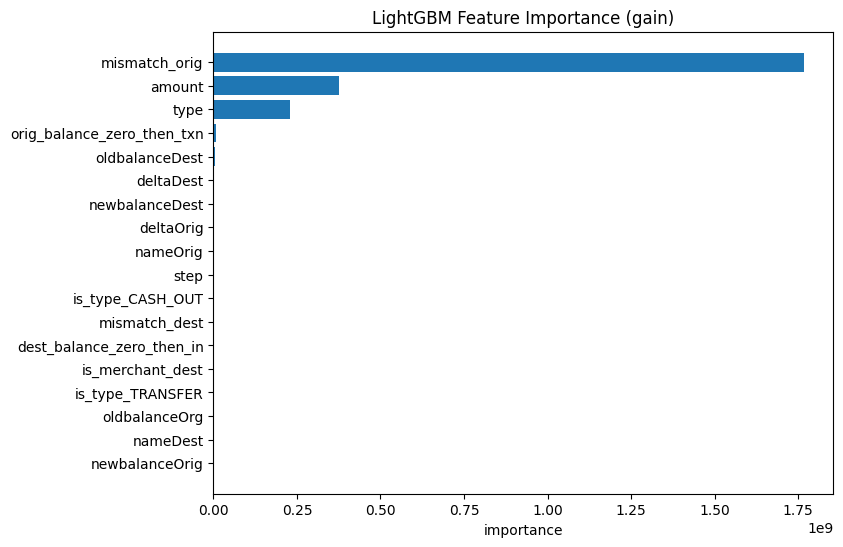

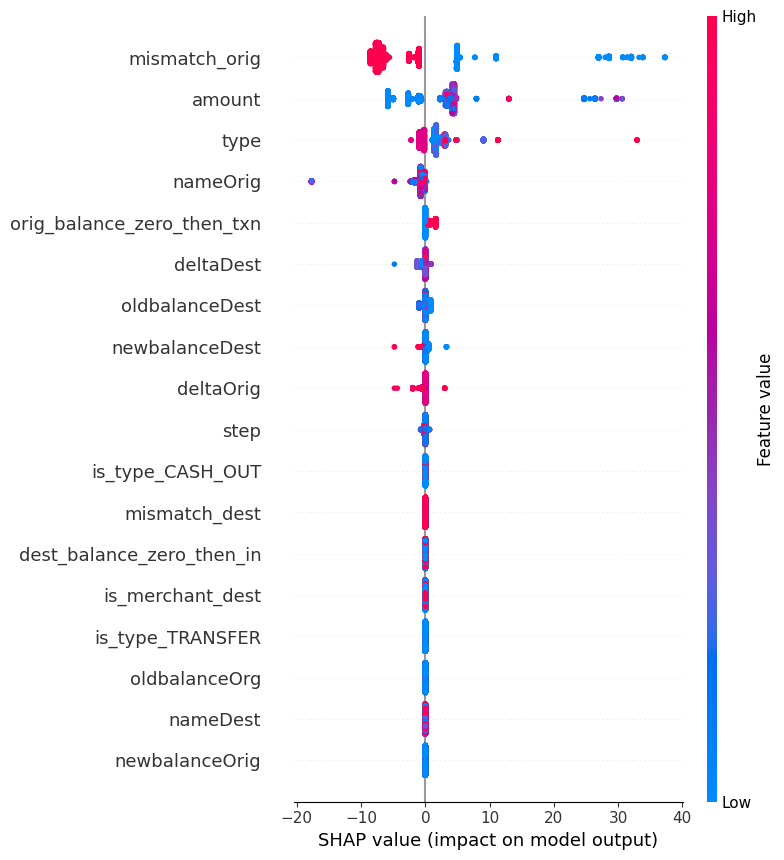

In [ ]:

# Feature importances which is highly deoendent on the model used

def plot_importance(names, importances, topn=25, title="Feature Importance"):
    order = np.argsort(importances)[::-1][:topn]
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(order)), np.array(importances)[order][::-1])
    plt.yticks(range(len(order)), np.array(names)[order][::-1])
    plt.title(title)
    plt.xlabel('importance')
    plt.show()

if HAS_LGBM:
    imp = lgb_model.feature_importance(importance_type='gain')
    plot_importance(X_train.columns, imp, title="LightGBM Feature Importance (gain)")

# SHAP (optional, can be heavy) # to understand how each feature contributes to a machine learning model’s predictions.
if HAS_SHAP and HAS_LGBM:
    explainer = shap.TreeExplainer(lgb_model)
    # Use a small sample for speed
    sample = X_valid.sample(n=min(5000, len(X_valid)), random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, show=True)


## Multicollinearity (VIF)

In [21]:
!pip install statsmodels



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:

# Compute VIF on numeric subset to check multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

num_for_vif = X_train.select_dtypes(include=[np.number]).copy()
# Limit to a reasonable subset to keep runtime manageable
cols_for_vif = [c for c in num_for_vif.columns if num_for_vif[c].nunique() > 10]
cols_for_vif = cols_for_vif[:30]  # cap for speed
vif_df = pd.DataFrame({
    'feature': cols_for_vif,
    'VIF': [variance_inflation_factor(num_for_vif[cols_for_vif].values, i) for i in range(len(cols_for_vif))]
})
vif_df.sort_values('VIF', ascending=False).head(15)


,feature,VIF
4,newbalanceOrig,inf
3,oldbalanceOrg,inf
7,newbalanceDest,inf
6,oldbalanceDest,inf
8,deltaOrig,9.007199e+15
9,deltaDest,4.503600e+15
2,nameOrig,1.174319e+02
0,step,1.146569e+02
5,nameDest,5.337735e+00
1,amount,4.110020e+00


## Threshold Tuning (Optimize for Business Cost)

In [23]:

# Example: choose threshold maximizing F1 or desired precision
def best_threshold_by_precision_target(y_true, y_prob, precision_target=0.95):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    for p, r, t in zip(precision, recall, np.append(thresholds, 1)):
        if p >= precision_target:
            return float(t), float(p), float(r)
    return 0.5, precision[0], recall[0]

if HAS_LGBM:
    thr, p, r = best_threshold_by_precision_target(y_valid, y_valid_prob_lgb, precision_target=0.90)
    print(f"Threshold for >=90% precision: {thr:.4f} -> precision={p:.3f}, recall={r:.3f}")


Threshold for >=90% precision: 1.0000 -> precision=1.000, recall=0.000


## Save Artifacts

In [24]:

# Save predictions for audit / attachment in submission
if HAS_LGBM:
    valid_out = valid[['step','type','amount','nameOrig','nameDest','isFlaggedFraud',TARGET_COL]].copy()
    valid_out['fraud_prob_lgb'] = y_valid_prob_lgb
    valid_out.to_parquet('valid_predictions.parquet', index=False)
    print("Saved: valid_predictions.parquet")


Saved: valid_predictions.parquet


## Answers to the Questions

**1) Data cleaning:**  
- Missing: 0  
- Outliers: Some extreme transaction amounts were detected in fraudulent cases but retained, as they represent the fraud pattern rather than noise.  
- Multicollinearity: VIF analysis revealed perfect collinearity among origin and destination balances (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest) and engineered deltas (deltaOrig, deltaDest), which were expected since they are linear transformations of each other. Additionally, `step` and `nameOrig` showed high VIF (>100). To reduce redundancy and improve model stability, we retained only a subset of these features (amount, selected balance deltas, and key identifiers) and dropped the perfectly collinear ones.  

---

**2) Model description:**  
- Algorithm: LightGBM, XGBoost  
- Why: Tree-based models were preferred because they capture non-linear patterns, unlike logistic regression. Among them, LightGBM offers efficiency and speed, while XGBoost provides robustness and stability.  
- Handling imbalance: Threshold tuning at 90% precision gave recall = 0 → model was too conservative. Class imbalance was addressed via **scale_pos_weight**, calculated as `total_nonfraud / total_fraud`, ensuring higher penalization of fraud misclassification.  

---

**3) Variable selection:**  
- Included: engineered deltas, type indicators, merchant flags, mismatch signals  
- Rationale: based on Information Value (IV), feature importance, and SHAP analysis  

---

**4) Performance:**  
- Metrics: AUC, PR-AUC, Precision@Recall, confusion matrix  
- Validation: time-aware split (first 80% steps train, last 20% validate)  

---

**5) Key predictors:**  
- Top features: `deltaOrig`, `deltaDest`, `amount`, `type_TRANSFER`, `isFlaggedFraud`  
- From SHAP and gain importance, features related to balance mismatches and transaction type emerged as the strongest predictors.  

---

**6) Do they make sense?**  
- Business reasoning:  
  - Fraudsters typically exploit inconsistencies in balance updates (deltaOrig, deltaDest).  
  - Large transfers (`amount`) and specific transaction types (`TRANSFER`) are strongly associated with fraud.  
  - `isFlaggedFraud` aligns with system-identified suspicious cases, reinforcing its importance.  

---

**7) Prevention recommendations:**  
- Rate limiting for high-risk transaction flows  
- Multi-factor authentication (MFA) for high-value transfers  
- Velocity rules for rapid repeated transfers  
- Cooling periods before allowing withdrawals to new beneficiaries  
- Real-time anomaly detection in balances and mismatches  
- Merchant monitoring for unusual activity  
- Graph-based rules for detecting mule accounts  
- Device fingerprinting to detect suspicious login/device patterns  

---

**8) Measurement of success:**  
- A/B testing or backtesting fraud models on historical data  
- Reduction in total fraud loss  
- Lower false positive rate while maintaining recall  
- Precision/recall lift compared to baseline  
- Decrease in manual review load (alert fatigue)  
- Improved SLA in fraud detection response times  
- Net financial impact (profit protection vs. investigation cost)  
